# Neural Networks in ``PyTorch``

The **MNIST dataset** consists of 60,000 images of hand written digit, where each image has size 28X28.

<img src="files/figures/mnist.png" width="600px"/>

We will define and train a deep neural network on the MNIST dataset. This is a **classification problem**.<br>

The definition and training of a neural network invoves the following steps:

0. Import **librairies**;
1. Get the **datasets** (train, validation and test);
2. Define the **dataloaders** from the datasets (train and test);
3. Define the **model**;
4. Define the **loss function**;
5. Define the **optimizer**;
7. **Train** the model (training loop);
8. Get the **results** (predict).

## 0. Librairies

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

In [2]:
#Importing required libraries for preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## 1. Datasets

- Load the train and test MNIST datasets using the following commands:<br>
```
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())
```
Each sample consists of a tensor (the image encoded in black and white), and a label (the digit that it represents).

- Examine the data (structure, dimension, etc).
- Create a function to visualize some data as an image.

In [3]:
class Data(Dataset):
    def __init__(self):
        train = pd.read_csv('archive/train.csv', index_col=0)
        train.drop(labels=["id"], axis=1, inplace=True)
        train.dropna(subset=["Arrival Delay in Minutes"], inplace=True)
        train.loc[train.satisfaction == "satisfied", "satisfaction"] = 1
        train.loc[train.satisfaction == "neutral or dissatisfied", "satisfaction"] = 0
        train["satisfaction"] = train["satisfaction"].astype('int64')
        train.drop(["Departure/Arrival time convenient", "Gate location", "Departure Delay in Minutes", "Arrival Delay in Minutes"], axis=1, inplace=True)
        label_to_encode = ["Gender", "Customer Type", "Type of Travel", "Class"]
        label_encoder = preprocessing.LabelEncoder()

        for label in label_to_encode :
            train[label] = label_encoder.fit_transform(train[label])
        x = train.drop("satisfaction", axis=1)
        x = x.astype(np.float32)
        self.x_train = torch.tensor(x.values)
        y = train["satisfaction"]
        y = y.astype(np.float32)
        self.y_train = torch.tensor(y.values)
        self.n_samples = train.shape[0]
    
    def __getitem__(self,index):
        return self.x_train[index],self.y_train[index]
    
    def __len__(self):
        return self.n_samples
        

In [4]:
class Data_test(Dataset):
    def __init__(self):
        test = pd.read_csv('archive/test.csv', index_col=0)
        test.drop(labels=["id"], axis=1, inplace=True)
        test.dropna(subset=["Arrival Delay in Minutes"], inplace=True)
        test.loc[test.satisfaction == "satisfied", "satisfaction"] = 1
        test.loc[test.satisfaction == "neutral or dissatisfied", "satisfaction"] = 0
        test["satisfaction"] = test["satisfaction"].astype('int64')
        test.drop(["Departure/Arrival time convenient", "Gate location", "Departure Delay in Minutes", "Arrival Delay in Minutes"], axis=1, inplace=True)
        label_to_encode = ["Gender", "Customer Type", "Type of Travel", "Class"]
        label_encoder = preprocessing.LabelEncoder()

        for label in label_to_encode :
            test[label] = label_encoder.fit_transform(test[label])
        x = test.drop("satisfaction", axis=1)
        x = x.astype(np.float32)
        self.x_test = torch.tensor(x.values)
        y = test["satisfaction"]
        y = y.astype(np.float32)
        self.y_test = torch.tensor(y.values)
        self.n_samples = test.shape[0]
    
    def __getitem__(self,index):
        return self.x_test[index],self.y_test[index]
    
    def __len__(self):
        return self.n_samples

In [5]:
train_dataset = Data()
test_dataset = Data_test()

In [6]:
train_dataset[1][0].shape, train_dataset[1][1]

(torch.Size([18]), tensor(0.))

In [7]:
test_dataset[1][0].shape, test_dataset[1][1]

(torch.Size([18]), tensor(1.))

In [8]:
len(train_dataset)

103594

In [9]:
train_dataset, val_dataset = random_split(train_dataset, [83594,20000])

In [10]:
len(train_dataset), len(val_dataset), len(test_dataset)

(83594, 20000, 25893)

## 2. Dataloaders

A **dataloader** creates batches of samples from a dataset so that they can be passed into a model.
- Create a train and test dataloaders using the following commands:
```
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)
```
- Note that dataloaders are not subscriptable.
- Try to catch one batch of the dataloader and examine it.
- Write a function that reshapes a batch of size $64 \times 1 \times 28 \times 28$ into a tensor of size $64 \times 784$.<br>
(use `torch.squeeze()`, `torch.reshape()`, `torch.flatten()`, `torch.transpose()`, etc.)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [12]:
def reshape_batch(batch):
    
    # note that this function moodifies the batch in-place (no return)
    batch_size = batch[0].shape[0]
    batch[0] = batch[0].view(batch_size, -1)
    
    return batch

In [13]:
for b in train_dataloader:
    break

In [14]:
b[0].shape

torch.Size([256, 18])

In [15]:
reshape_batch(b)

[tensor([[ 0.,  0., 30.,  ...,  1.,  4.,  1.],
         [ 0.,  0., 43.,  ...,  4.,  5.,  2.],
         [ 0.,  0., 70.,  ...,  3.,  5.,  5.],
         ...,
         [ 0.,  0., 30.,  ...,  3.,  4.,  2.],
         [ 1.,  1., 20.,  ...,  2.,  3.,  5.],
         [ 1.,  0., 45.,  ...,  1.,  2.,  4.]]),
 tensor([0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
         1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0

In [16]:
b[0].shape

torch.Size([256, 18])

## 3. Model

- Define and instanciate a **neural network** with the following feaures:
    - hidden layer 1: 256 neurons, relu activation function
    - hidden layer 2: 256 neurons, relu activation function
    - hidden layer 3: 128 neurons, relu activation function
    - hidden layer 4: 64 neurons, relu activation function
    - output layer: 10 neurons

In [17]:
class Network(nn.Module):

    def __init__(self):
        
        super(Network, self).__init__()
        
        self.fc1 = nn.Linear(18, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 2)
        

    def forward(self, x):
        
        x = self.fc1(x)
        x = nn.ReLU()(x) #fonction d'activation
        
        x = self.fc2(x)
        x = nn.ReLU()(x)
        
        x = self.fc3(x)
        x = nn.ReLU()(x)
        
        x = self.fc4(x)
        x = nn.ReLU()(x)
        
        x = self.fc5(x)
        
        
        
        return x

In [18]:
network = Network()

In [19]:
# Put network to GPU if exists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)

Network(
  (fc1): Linear(in_features=18, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

In [20]:
network

Network(
  (fc1): Linear(in_features=18, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=2, bias=True)
)

## 4. Loss

- Define a **cross entropy loss** with the following command:<br>
```
loss = nn.CrossEntropyLoss()
```
- Try to understand this loss object:<br>
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

In [21]:
loss = nn.CrossEntropyLoss()

## 5. Optimizer

- Define an **SGD optimizer** with the following command:<br>
```
optimizer = torch.optim.SGD(network.parameters(), lr=0.005)
```
- Try to understand this object:<br>
https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

In [22]:
optimizer = torch.optim.SGD(network.parameters(), lr=0.006)

## 6. Training

- Define a **training loop** for you model.
- The key instructions are:
    - ``optimizer.zero_grad()``: reset gradients to 0
    - ``loss.backward()``      : compute new gradients
    - ``optimizer.step()``     : uptdate weights
- Train the model for 20 epochs.
- Plot the training loss.

In [23]:
def train(model, loss=None, optimizer=None, train_dataloader=None, val_dataloader=None, nb_epochs=50):
    """Training loop"""

    min_val_loss = torch.inf
    train_losses = []
    val_losses = []

    # Iterrate over epochs
    for e in range(nb_epochs):

        # Training
        train_loss = 0.0

        for data, labels in train_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)   # casting to long
                data, labels = data.to(device), labels.to(device)
                
            
            # Reset gradients to 0
            optimizer.zero_grad()

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute training loss
            current_loss = loss(targets, labels)
            train_loss += current_loss.item()

            # Compute gradients
            current_loss.backward()

            # Update weights
            optimizer.step()
        
        # Validation
        val_loss = 0.0

        # Put model in eval mode
        model.eval()

        for data, labels in val_dataloader:

            # Transfer data to GPU if available
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
                labels = labels.type(torch.LongTensor)   # casting to long
                data, labels = data.to(device), labels.to(device)

            # Forward Pass (on reshaped data)
            data, labels = reshape_batch([data, labels])
            targets = model(data)

            # Compute validation loss
            current_loss = loss(targets, labels)
            val_loss += current_loss.item()
        
        # Prints
        print(f"Epoch {e+1}/{nb_epochs} \
                \t Training Loss: {train_loss/len(train_dataloader):.3f} \
                \t Validation Loss: {val_loss/len(val_dataloader):.3f}")
        
        train_losses.append(train_loss/len(train_dataloader))
        val_losses.append(val_loss/len(val_dataloader))

        # Save model if val loss decreases
        if val_loss < min_val_loss:

            min_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            
    return train_losses, val_losses

In [24]:
train_losses, val_losses = train(model=network, loss=loss, optimizer=optimizer, 
                                 train_dataloader=train_dataloader, val_dataloader=val_dataloader, 
                                 nb_epochs=50)

Epoch 1/50                 	 Training Loss: 1.651                 	 Validation Loss: 0.664
Epoch 2/50                 	 Training Loss: 0.654                 	 Validation Loss: 0.654
Epoch 3/50                 	 Training Loss: 0.646                 	 Validation Loss: 0.648
Epoch 4/50                 	 Training Loss: 0.641                 	 Validation Loss: 0.645
Epoch 5/50                 	 Training Loss: 0.636                 	 Validation Loss: 0.648
Epoch 6/50                 	 Training Loss: 0.634                 	 Validation Loss: 0.650
Epoch 7/50                 	 Training Loss: 0.635                 	 Validation Loss: 0.647
Epoch 8/50                 	 Training Loss: 0.630                 	 Validation Loss: 0.639
Epoch 9/50                 	 Training Loss: 0.629                 	 Validation Loss: 0.649
Epoch 10/50                 	 Training Loss: 0.638                 	 Validation Loss: 0.659
Epoch 11/50                 	 Training Loss: 0.635                 	 Validation Loss: 0.6

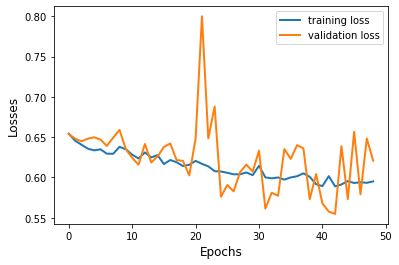

In [32]:
# Plot losses
plt.plot(range(len(train_losses[1:])), train_losses[1:], 
         linewidth=2.0, 
         label='training loss')

plt.plot(range(len(val_losses[1:])), val_losses[1:], 
         linewidth=2.0, 
         label='validation loss')

plt.xlabel("Epochs", size=12)
plt.ylabel("Losses", size=12)
plt.legend()

plt.savefig('figures/losses.pdf') 
plt.show()

## 6. Testing

- Write a ``predict`` function
    - use ``with torch.no_grad():``
- Compute the accuracy and classification report of the train and test sets.

In [33]:
def predict(model, test_dataloader):

    labels_l = []
    preds_l = []
    
    # Put model in eval mode
    model.eval()
    
    # Testing loop
    with torch.no_grad():
        
        for i, batch in enumerate(test_dataloader):
            
            data, labels = reshape_batch(batch)
            data, labels = data.to(device), labels.to(device) #sinon bug
            
            labels_l.extend(labels.tolist())
            
            preds = model.to(device)
            preds = model(data)
            
            preds = torch.argmax(preds, dim=1)
            preds_l.extend(preds.tolist())
    
    return labels_l, preds_l

In [34]:
train_labels, train_preds = predict(network, train_dataloader)
test_labels, test_preds = predict(network, test_dataloader)

In [35]:
print(classification_report(train_labels, train_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6130    0.9539    0.7464     47384
         1.0     0.7785    0.2121    0.3334     36210

    accuracy                         0.6326     83594
   macro avg     0.6957    0.5830    0.5399     83594
weighted avg     0.6847    0.6326    0.5675     83594



In [36]:
print(classification_report(test_labels, test_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.6066    0.9526    0.7412     14528
         1.0     0.7765    0.2103    0.3310     11365

    accuracy                         0.6268     25893
   macro avg     0.6915    0.5815    0.5361     25893
weighted avg     0.6812    0.6268    0.5612     25893



## 7. Save

- Save your trained model.
- Try to reload it and see if it works.
- Use the following instructions
```
torch.save(model.state_dict(), <path>)
...
network_2.load_state_dict(torch.load(<path>))
network_2.eval()
```

In [ ]:
cwd = os.getcwd()
path = os.path.join(cwd, "model.pt")
path_2 = os.path.join(cwd, "best_model.pt")

In [ ]:
# Save last model
torch.save(network.state_dict(), path) 

In [ ]:
# Load best model
network_2 = Network()

network_2.load_state_dict(torch.load(path))
network_2.eval()

In [ ]:
test_labels, test_preds = predict(network_2, test_dataloader)

In [ ]:
print(classification_report(test_labels, test_preds))